In [1]:
'''
Changing properly the features, this Notebook is valid for any QEG 2D of this work.
'''

from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.model_selection import GridSearchCV
import pandas as pd
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectPercentile, SelectKBest, f_regression, chi2, VarianceThreshold
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import sympy
from sympy import Matrix
from scipy.linalg import null_space
import itertools

In [2]:
edges = [np.array([ 0.,  380.899,  761.798, 1142.697, 1523.596, 1904.495, 2285.394, 2666.293, 3047.192, 3428.091, 3808.99 ]),
                  np.array([1.        , 1.83333333, 2.66666667, 3.5       , 4.33333333, 5.16666667, 6.        ])
        ]

In [3]:
def define_system(sample):
    
    
    H, edges = np.histogramdd(sample, bins = [10, 6], range = [None, [1, 6]])
    edges = [np.array([ 0.,  380.899,  761.798, 1142.697, 1523.596, 1904.495, 2285.394, 2666.293, 3047.192, 3428.091, 3808.99 ]),
                  np.array([1.        , 1.83333333, 2.66666667, 3.5       , 4.33333333, 5.16666667, 6.        ])
        ]
    
    n_variables = np.shape(sample)[1]
    alpha_x1 = (edges[0] + (edges[0][1]-edges[0][0])/(2))[:-1]
    alpha_x2 = (edges[1] + (edges[1][1]-edges[1][0])/(2))[:-1]

    combinations = np.array(list(itertools.product(alpha_x1, alpha_x2)))

    m = np.zeros([int(n_variables + (n_variables**2 - n_variables)/2 + n_variables), len(combinations)]) ## define matrix m

    for i in range(n_variables):                            ## First rows: bins
        m[i] = combinations.transpose()[i]

    variance = []
    for i in range(n_variables):
        for j in range(n_variables):
            if i >= j:
                variance.append( (m[i] - np.mean(sample[:, i])) * (m[j] - np.mean(sample[:, j])) )

    for i in range(len(variance)):                          ## then, variances
        m[i + n_variables] = variance[i]

    D = np.array([np.ones(np.shape(m)[1])])
    E = np.vstack([m, D])
    rho = null_space(D)
    t = null_space(E)

    p = np.zeros([np.shape(m)[0] + 1, np.shape(m)[1]])
    p[0] = np.ones(np.shape(m)[1]) * 1/np.shape(m)[1]

    p = p[0]
    
    return(H, p, m, rho, t)

def correct(N, p, m, rho, t, eps1, eps2, eps3, eps4, eps5):
    
    A = np.zeros([np.shape(rho)[1], np.shape(rho)[1]])
    b = np.zeros(np.shape(rho)[1])
    R = np.zeros([N, 60])
    
    for k in range(N):
        for i in range(np.shape(t)[1]):
            for j in range(np.shape(rho)[1]):
                A[i][j] = np.dot(t[:, i], np.dot(np.diag(-1/p), rho[:, j]))

        for j in range(np.shape(rho)[1]):

            A[-5][j] = np.dot(rho[:, j], m[0])
            A[-4][j] = np.dot(rho[:, j], m[1])
            A[-3][j] = np.dot(rho[:, j], m[2])
            A[-2][j] = np.dot(rho[:, j], m[3])
            A[-1][j] = np.dot(rho[:, j], m[4])

        for i in range(np.shape(t)[1]):
            b[i] = np.dot((1 + np.log(p)), t[:, i])

        b[-5] = eps1
        b[-4] = eps2
        b[-3] = eps3
        b[-2] = eps4
        b[-1] = eps5


        mu = np.linalg.solve(A, b)
        delta_c = np.dot(mu, rho.transpose())

        p = p + delta_c
        R[k] = p
        
    return(R)

def auto_correct(H, p, m, rho, t):
    for i in range(np.shape(m)[0]):
        
        res = np.dot(m[i], H.flatten()/sum(H.flatten())) - np.dot(m[i], p)
        if abs(res)>=.1:
            eps = res/100
            a = np.zeros(np.shape(m)[0])
            a[i] = eps
            l = correct(100, p, m, rho, t, a[0], a[1], a[2], a[3], a[4])
            p = l[-1]
            
    return(p)

In [4]:
Data = pd.read_excel(r'database.xlsx', index_col=0)

In [5]:
import tqdm
rows_to_drop = []
for i in tqdm.tqdm(range(len(Data))):
    if 'Cu' in Data.index[i] or 'Fe' in Data.index[i] or 'Ni' in Data.index[i] or 'O' in Data.index[i] or Data['Tc'].iloc[i]>50:
        rows_to_drop.append(Data.index[i])

100%|████████████████████████████████████████████████████████████████████████| 16763/16763 [00:00<00:00, 165915.35it/s]


In [6]:
data_reduced = Data.drop(rows_to_drop)
train_df, test_df = train_test_split(data_reduced, test_size = 0.15, random_state = 0)

train_df['class'] = 0
for i in range(len(train_df)):
    if train_df['Tc'].iloc[i] >= 15:
        train_df['class'].iloc[i] = 1
        
test_df['class'] = 0
for i in range(len(test_df)):
    if test_df['Tc'].iloc[i] >= 15:
        test_df['class'].iloc[i] = 1

class_data = test_df[['MagpieData range MeltingT', '0-norm', 'class']]
class_data[['bin_dimension_1', 'bin_dimension_2']] = 0

In [9]:
'''J0 and J1 stand for p0 and p1 in the main text. For the non bagged case, 
the chosen_idx is all the indices sorted from 0 to the len of the train_df
and N_bagging=1.
'''

N_bagging = 100

J0 = np.zeros([N_bagging, 60])
J1 = np.zeros([N_bagging, 60])

for i in tqdm.tqdm(range(N_bagging)):
    
    chosen_idx = np.random.choice(len(train_df), replace=True, size=len(train_df))
    sampled_data = train_df.iloc[chosen_idx]
    data0 = sampled_data[sampled_data['Tc']<15]
    data1 = sampled_data[sampled_data['Tc']>=15]
    sample0 = np.array([data0['MagpieData range MeltingT'].values, data0['0-norm'].values]).transpose()
    sample1 = np.array([data1['MagpieData range MeltingT'].values, data1['0-norm'].values]).transpose()
    
    H0, p0, m0, rho0, t0 = define_system(sample0)
    H1, p1, m1, rho1, t1 = define_system(sample1)
    
    J0[i] = auto_correct(H0, p0, m0, rho0, t0)
    J1[i] = auto_correct(H1, p1, m1, rho1, t1)
    
    

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:17:54<00:00, 46.74s/it]


In [11]:
len_0 = len(train_df[train_df['Tc'] < 15])
len_1 = len(train_df[train_df['Tc'] >= 15])

result = len_1*np.mean(J1, axis = 0)-len_0*np.mean(J0, axis = 0)-np.min(len_1*np.mean(J1, axis = 0)-len_0*np.mean(J0, axis = 0))
result = result/sum(result)

In [ ]:
for i in range(len(class_data)):

    if class_data['MagpieData range MeltingT'].iloc[i] < edges[0][1]:
        class_data['bin_dimension_1'].iloc[i] = 0
    elif class_data['MagpieData range MeltingT'].iloc[i] < edges[0][2]:
        class_data['bin_dimension_1'].iloc[i] = 1
    elif class_data['MagpieData range MeltingT'].iloc[i] < edges[0][3]:
        class_data['bin_dimension_1'].iloc[i] = 2
    elif class_data['MagpieData range MeltingT'].iloc[i] < edges[0][4]:
        class_data['bin_dimension_1'].iloc[i] = 3
    elif class_data['MagpieData range MeltingT'].iloc[i] < edges[0][5]:
        class_data['bin_dimension_1'].iloc[i] = 4
    elif class_data['MagpieData range MeltingT'].iloc[i] < edges[0][6]:
        class_data['bin_dimension_1'].iloc[i] = 5
    elif class_data['MagpieData range MeltingT'].iloc[i] < edges[0][7]:
        class_data['bin_dimension_1'].iloc[i] = 6
    elif class_data['MagpieData range MeltingT'].iloc[i] < edges[0][8]:
        class_data['bin_dimension_1'].iloc[i] = 7
    elif class_data['MagpieData range MeltingT'].iloc[i] < edges[0][9]:
        class_data['bin_dimension_1'].iloc[i] = 8
    else:
        class_data['bin_dimension_1'].iloc[i] = 9

        
for i in range(len(class_data)):

    if class_data['0-norm'].iloc[i] < edges[1][1]:
        class_data['bin_dimension_2'].iloc[i] = 0
    elif class_data['0-norm'].iloc[i] < edges[1][2]:
        class_data['bin_dimension_2'].iloc[i] = 1
    elif class_data['0-norm'].iloc[i] < edges[1][3]:
        class_data['bin_dimension_2'].iloc[i] = 2
    elif class_data['0-norm'].iloc[i] < edges[1][4]:
        class_data['bin_dimension_2'].iloc[i] = 3
    elif class_data['0-norm'].iloc[i] < edges[1][5]:
        class_data['bin_dimension_2'].iloc[i] = 4
    else:
        class_data['bin_dimension_2'].iloc[i] = 5

In [89]:
class_data['probability'] = result.reshape(10, -1)[class_data['bin_dimension_1'], class_data['bin_dimension_2']]

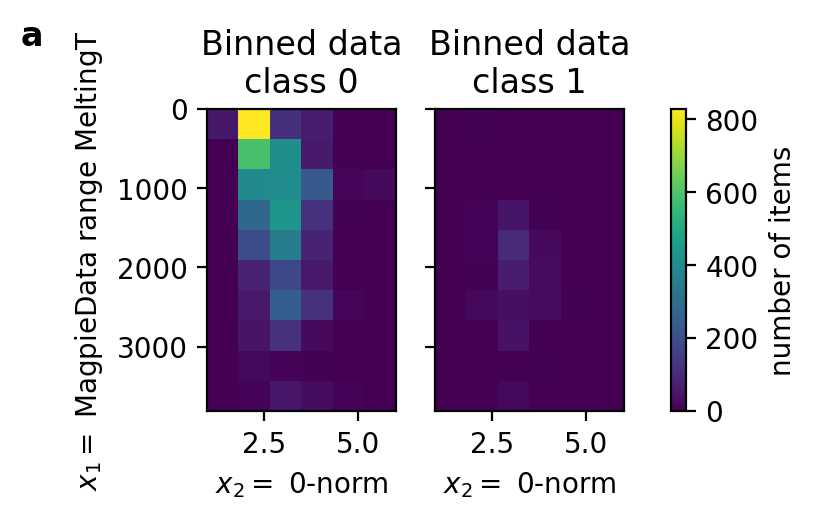

In [115]:
'''Figure example'''

fig, axs = plt.subplots(1, 2, dpi = 200, figsize = (6, 2))
images = []

images.append(axs[0].imshow(H0, cmap='viridis', extent = [min_Magpie, max_Magpie, max_ionic, min_ionic]))
axs[0].set_title('Binned data\nclass 0')
axs[0].set_xlabel(r'$x_2=$ 0-norm')
axs[0].set_ylabel(r'$x_1=$ MagpieData range MeltingT')
axs[0].set_aspect(.0021)
axs[0].label_outer()

images.append(axs[1].imshow(H1, cmap='viridis', extent = [min_Magpie, max_Magpie, max_ionic, min_ionic]))
axs[1].set_title('Binned data\nclass 1')
axs[1].set_xlabel(r'$x_2=$ 0-norm')
axs[1].set_aspect(.0021)
axs[1].label_outer()


vmin = min(image.get_array().min() for image in images)
vmax = max(image.get_array().max() for image in images)
norm = colors.Normalize(vmin=vmin, vmax=vmax)
for im in images:
    im.set_norm(norm)
fig.colorbar(images[0], ax=axs, orientation='vertical', fraction=.5, label = 'number of items')

def update(changed_image):
    for im in images:
        if (changed_image.get_cmap() != im.get_cmap()
                or changed_image.get_clim() != im.get_clim()):
            im.set_cmap(changed_image.get_cmap())
            im.set_clim(changed_image.get_clim())
            
for im in images:
    im.callbacksSM.connect('changed', update)

plt.annotate(r'$\mathbf{a}$', xy=(1.1, 5), xytext=(-10, -800), fontsize = 12,
            ) 

plt.show()

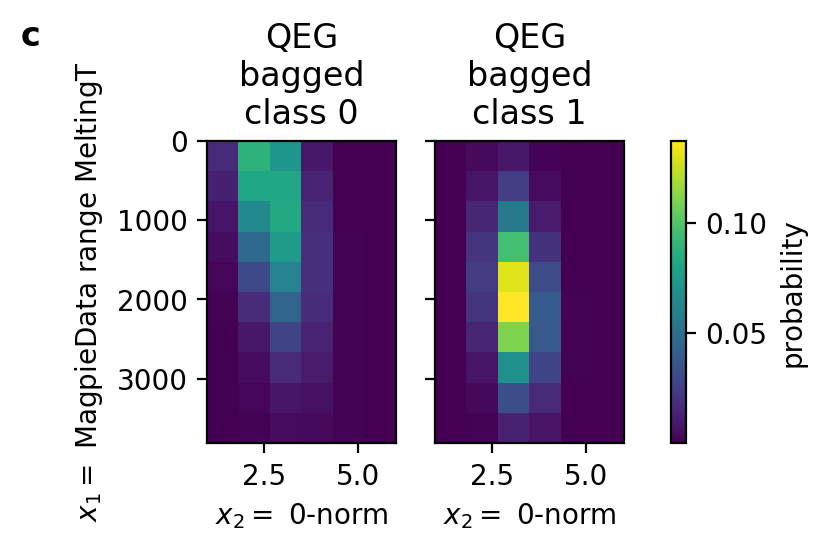

In [119]:
fig, axs = plt.subplots(1, 2, dpi = 200, figsize = (6, 2))
images = []

images.append(axs[0].imshow(np.mean(J0, axis = 0).reshape(10, -1), cmap='viridis', extent = [min_Magpie, max_Magpie, max_ionic, min_ionic]))
axs[0].set_title('QEG\nbagged\nclass 0')
axs[0].set_xlabel(r'$x_2=$ 0-norm')
axs[0].set_ylabel(r'$x_1=$ MagpieData range MeltingT')
axs[0].set_aspect(.0021)
axs[0].label_outer()

images.append(axs[1].imshow(np.mean(J1, axis = 0).reshape(10, -1), cmap='viridis', extent = [min_Magpie, max_Magpie, max_ionic, min_ionic]))
axs[1].set_title('QEG\nbagged\nclass 1')
axs[1].set_xlabel(r'$x_2=$ 0-norm')
axs[1].set_aspect(.0021)
axs[1].label_outer()


vmin = min(image.get_array().min() for image in images)
vmax = max(image.get_array().max() for image in images)
norm = colors.Normalize(vmin=vmin, vmax=vmax)
for im in images:
    im.set_norm(norm)
fig.colorbar(images[0], ax=axs, orientation='vertical', fraction=.5, label = 'probability')

def update(changed_image):
    for im in images:
        if (changed_image.get_cmap() != im.get_cmap()
                or changed_image.get_clim() != im.get_clim()):
            im.set_cmap(changed_image.get_cmap())
            im.set_clim(changed_image.get_clim())
            
for im in images:
    im.callbacksSM.connect('changed', update)

plt.annotate(r'$\mathbf{c}$', xy=(1.1, 5), xytext=(-10, -1200), fontsize = 12,
            )

plt.show()